# Finding alternatives to DGLLife for Solubility prediction

In [294]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library_sorted.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

import torch
import pyarrow.parquet as pq
table = pq.read_table('../../dgym-data/sizes.parquet')[0]
sizes = torch.tensor(table.to_numpy())

Using AqSolDB.

In [2]:
from tdc.single_pred import ADME
data = ADME(name = 'Solubility_AqSolDB')
split = data.get_split()

Found local copy...
Loading...
Done!


In [319]:
%%time
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem

fpgen = AllChem.GetRDKitFPGenerator()
mols = [dg.molecule.Molecule(d) for d in split['train']['Drug']]
y = split['train']['Y'].values

CPU times: user 414 ms, sys: 0 ns, total: 414 ms
Wall time: 414 ms


In [348]:
%%time

from bitarray import bitarray

def make_fingerprints(molecules):

    # Convert binary data to a bit array
    fingerprint_type = fingerprints.get_fingerprint_type()
    fingerprint_type = fingerprint_type(nBits=2048)
    
    fps = []
    for m in molecules:
        f = fingerprint_type.from_smi(m.smiles)
        fingerprint = bitarray()
        fingerprint.frombytes(f)
        fps.append(fingerprint)

    X = np.unpackbits(fps, axis=1)
    return X

CPU times: user 10 µs, sys: 4 µs, total: 14 µs
Wall time: 15.7 µs


In [349]:
import numpy as np
from catboost import Pool, CatBoostRegressor

cb = CatBoostRegressor()
X_train = make_fingerprints(mols)
cb.fit(X_train, y)

*** Open Babel Warning  in ParseSmiles
  Ignoring stereochemistry. Not enough connections to this atom. 
*** Open Babel Warning  in ParseSmiles
  Ignoring stereochemistry. Not enough connections to this atom. 
*** Open Babel Warning  in CreateCisTrans
  Error in cis/trans stereochemistry specified for the double bond



Learning rate set to 0.055666
0:	learn: 2.3511762	total: 4.76ms	remaining: 4.75s
1:	learn: 2.3220230	total: 9.05ms	remaining: 4.51s
2:	learn: 2.2848712	total: 14.1ms	remaining: 4.7s
3:	learn: 2.2550255	total: 18.6ms	remaining: 4.63s
4:	learn: 2.2238838	total: 22.6ms	remaining: 4.5s
5:	learn: 2.1954592	total: 26.5ms	remaining: 4.39s
6:	learn: 2.1687932	total: 30.9ms	remaining: 4.38s
7:	learn: 2.1453402	total: 35.9ms	remaining: 4.45s
8:	learn: 2.1249147	total: 40.6ms	remaining: 4.47s
9:	learn: 2.1072298	total: 44.7ms	remaining: 4.43s
10:	learn: 2.0865577	total: 49.1ms	remaining: 4.41s
11:	learn: 2.0657520	total: 53.9ms	remaining: 4.44s
12:	learn: 2.0460925	total: 58.1ms	remaining: 4.41s
13:	learn: 2.0310173	total: 62.7ms	remaining: 4.42s
14:	learn: 2.0157161	total: 67.3ms	remaining: 4.42s
15:	learn: 2.0002237	total: 71.5ms	remaining: 4.4s
16:	learn: 1.9854667	total: 75.5ms	remaining: 4.37s
17:	learn: 1.9725429	total: 80ms	remaining: 4.37s
18:	learn: 1.9621210	total: 83.9ms	remaining: 4.3

In [350]:
%%time
preds = cb.predict(X_train)

CPU times: user 2.17 s, sys: 124 ms, total: 2.3 s
Wall time: 2.05 s


In [351]:
mols_test = [dg.molecule.Molecule(d) for d in split['test']['Drug']]
y_test = split['test']['Y'].values
X_test = make_fingerprints(mols_test)
preds = cb.predict(X_test)

In [352]:
from scipy.stats import pearsonr

pearsonr(preds, y_test)

PearsonRResult(statistic=0.8253481432291261, pvalue=0.0)

In [353]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, preds, squared=False)

1.316894852888839

<Axes: >

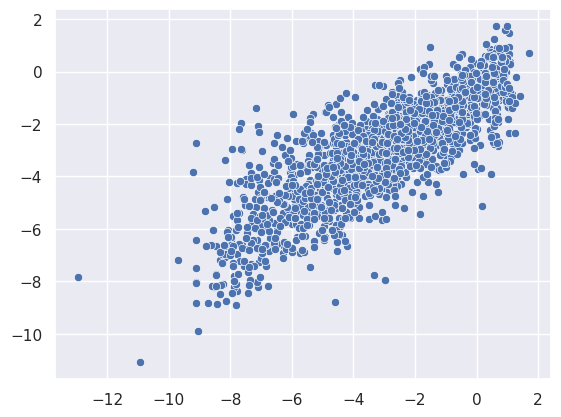

In [355]:
import seaborn as sns

sns.set()
sns.scatterplot(y=preds, x=y_test)

In [360]:
from rdkit.DataStructs import cDataStructs
from DeepPurpose import CompoundPred as models
from DeepPurpose.utils import *

from tdc import BenchmarkGroup
group = BenchmarkGroup(name = 'ADMET_Group', path = 'data/')

import warnings
warnings.filterwarnings("ignore")

drug_encoding = 'RDKit2D'

if drug_encoding not in [
    'RDKit2D', 'Morgan', 'CNN', 'NeuralFP', 'MPNN', 'AttentiveFP', 'AttrMasking', 'ContextPred']:
    raise ValueError("You have to specify from 'RDKit2D', 'Morgan', 'CNN', 'NeuralFP', 'MPNN', 'AttentiveFP', 'AttrMasking', 'ContextPred'!")

if drug_encoding == 'RDKit2D':
    drug_encoding = 'rdkit_2d_normalized'
    
if drug_encoding in ['NeuralFP', 'AttentiveFP', 'AttrMasking', 'ContextPred']:
    drug_encoding = 'DGL_' + drug_encoding

predictions_all_seeds = {}
results_all_seeds = {}

predictions = {}
for benchmark in group:
    train, valid = group.get_train_valid_split(
        benchmark = benchmark['name'], split_type = 'default', seed = seed)

    train = data_process(X_drug = train.Drug.values, y = train.Y.values, 
                    drug_encoding = drug_encoding,
                    split_method='no_split')

    val = data_process(X_drug = valid.Drug.values, y = valid.Y.values, 
                    drug_encoding = drug_encoding,
                    split_method='no_split')

    test = data_process(X_drug = benchmark['test'].Drug.values, y = benchmark['test'].Y.values, 
                    drug_encoding = drug_encoding,
                    split_method='no_split')

    config = generate_config(
        drug_encoding = drug_encoding, 
        cls_hidden_dims = [512], 
        train_epoch = 50, 
        LR = 0.001, 
        batch_size = 128,
    )

    model = models.model_initialize(**config)
    model.train(train, val, test, verbose = False)
    y_pred = model.predict(test)
    predictions[benchmark['name']] = y_pred

results = group.evaluate(predictions)
predictions_all_seeds['seed ' + str(seed)] = predictions
results_all_seeds['seed ' + str(seed)] = results

tdc.BenchmarkGroup will be deprecated soon. Please use tdc.benchmark_group.XXX_group and check out the examples on website!
Found local copy...
--- caco2_wang ---
generating training, validation splits...
100%|███████████████████████████| 728/728 [00:00<00:00, 3374.32it/s]


Drug Property Prediction Mode...
in total: 637 drugs
encoding drug...
unique drugs: 634
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 91 drugs
encoding drug...
unique drugs: 91
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 182 drugs
encoding drug...
unique drugs: 181
do not do train/test split on the data for already splitted data


--- hia_hou ---
generating training, validation splits...


predicting...


100%|███████████████████████████| 461/461 [00:00<00:00, 4892.30it/s]

Drug Property Prediction Mode...
in total: 403 drugs
encoding drug...
unique drugs: 403


do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 58 drugs
encoding drug...
unique drugs: 58
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 117 drugs
encoding drug...
unique drugs: 117
do not do train/test split on the data for already splitted data


--- pgp_broccatelli ---
generating training, validation splits...


predicting...


100%|███████████████████████████| 973/973 [00:00<00:00, 2934.32it/s]


Drug Property Prediction Mode...
in total: 851 drugs
encoding drug...
unique drugs: 846
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 122 drugs
encoding drug...
unique drugs: 121
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 245 drugs
encoding drug...
unique drugs: 245
do not do train/test split on the data for already splitted data


--- bioavailability_ma ---
generating training, validation splits...


predicting...


100%|███████████████████████████| 512/512 [00:00<00:00, 4823.90it/s]

Drug Property Prediction Mode...
in total: 448 drugs
encoding drug...
unique drugs: 448


do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 64 drugs
encoding drug...
unique drugs: 64
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 128 drugs
encoding drug...
unique drugs: 128
do not do train/test split on the data for already splitted data


--- lipophilicity_astrazeneca ---
generating training, validation splits...


predicting...


100%|█████████████████████████| 3360/3360 [00:00<00:00, 3666.64it/s]


Drug Property Prediction Mode...
in total: 2940 drugs
encoding drug...
unique drugs: 2940


Could not compute PEOE_VSA10 for molecule
Traceback (most recent call last):
  File "/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/descriptastorus/descriptors/rdNormalizedDescriptors.py", line 74, in applyNormalizedFunc
    return cdfs[name](rdDescriptors.applyFunc(name,m))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/descriptastorus/descriptors/rdNormalizedDescriptors.py", line 61, in cdf
    v = dist.cdf(np.clip(v, minV, maxV), loc=loc, scale=scale, *arg)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py", line 2080, in cdf
    goodargs = argsreduce(cond, *((x,)+args))
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py", line 606, in argsreduce
    *newargs, con

descriptastorus not found this smiles: CCN(C(=O)Cc1ccc(S(C)(=O)=O)cc1)C1CCN(CCC(c2ccccc2)c2ccc(C#N)cc2)CC1 convert to all 0 features


Could not compute FractionCSP3 for molecule
Traceback (most recent call last):
  File "/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/descriptastorus/descriptors/rdNormalizedDescriptors.py", line 74, in applyNormalizedFunc
    return cdfs[name](rdDescriptors.applyFunc(name,m))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/descriptastorus/descriptors/rdNormalizedDescriptors.py", line 61, in cdf
    v = dist.cdf(np.clip(v, minV, maxV), loc=loc, scale=scale, *arg)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py", line 2081, in cdf
    place(output, cond, self._cdf(*goodargs))
                        ^^^^^^^^^^^^^^^^^^^^
  File "/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py", line 1958, in _cdf
    return self._cdfv

descriptastorus not found this smiles: COc1cc(OC)c(S(=O)(=O)NCc2ccccc2N2CCCCC2)cc1NC(=O)CCC(=O)O convert to all 0 features


Could not compute Ipc for molecule
Traceback (most recent call last):
  File "/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/descriptastorus/descriptors/rdNormalizedDescriptors.py", line 74, in applyNormalizedFunc
    return cdfs[name](rdDescriptors.applyFunc(name,m))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/descriptastorus/descriptors/rdNormalizedDescriptors.py", line 61, in cdf
    v = dist.cdf(np.clip(v, minV, maxV), loc=loc, scale=scale, *arg)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/numpy/core/fromnumeric.py", line 2169, in clip
    return _wrapfunc(a, 'clip', a_min, a_max, out=out, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/numpy/core/fromnumeric.py", line 56, in _wrapfunc
    return _wrapit(obj, method, *args,

descriptastorus not found this smiles: O=C(c1cc(Cc2n[nH]c(=O)c3ccccc23)ccc1F)N1CCN(C(=O)C2CCOC2)CC1 convert to all 0 features


function application failed (BalabanJ->C#CCn1c(=O)c2c(-c3cncn3C)n(Cc3ccnc4ccc(Cl)cc34)nc2n(CC2CC2)c1=O)
Traceback (most recent call last):
  File "/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/descriptastorus/descriptors/rdDescriptors.py", line 336, in applyFunc
    return FUNCS[name](m)
           ^^^^^^^^^^^^^^
  File "/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/rdkit/Chem/GraphDescriptors.py", line -1, in BalabanJ
KeyboardInterrupt
Could not compute BalabanJ for molecule
Traceback (most recent call last):
  File "/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/descriptastorus/descriptors/rdNormalizedDescriptors.py", line 74, in applyNormalizedFunc
    return cdfs[name](rdDescriptors.applyFunc(name,m))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/descriptastorus/descriptors/rdNormalizedDescriptors.py", line 61, in cdf
    v = dist.cdf(np.clip(v, minV, ma

descriptastorus not found this smiles: CC(C)Cn1c(=O)n(C)c(=O)c2c(SCCCO)c(Cc3ccccc3C(F)(F)F)sc21 convert to all 0 features
descriptastorus not found this smiles: Cc1ccc(Oc2ccc(OCC(=O)Nc3ccncc3)cc2)cc1 convert to all 0 features
descriptastorus not found this smiles: Cc1cccc(Nc2ccncc2S(=O)(=O)NC(=O)NC(C)C)c1 convert to all 0 features


Could not compute fr_prisulfonamd for molecule
Traceback (most recent call last):
  File "/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/descriptastorus/descriptors/rdNormalizedDescriptors.py", line 74, in applyNormalizedFunc
    return cdfs[name](rdDescriptors.applyFunc(name,m))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/descriptastorus/descriptors/rdNormalizedDescriptors.py", line 61, in cdf
    v = dist.cdf(np.clip(v, minV, maxV), loc=loc, scale=scale, *arg)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py", line 2081, in cdf
    place(output, cond, self._cdf(*goodargs))
                        ^^^^^^^^^^^^^^^^^^^^
  File "/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py", line 957, in _cdf
    return _lazywhere(

do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 420 drugs
encoding drug...
unique drugs: 420
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 840 drugs
encoding drug...
unique drugs: 840
do not do train/test split on the data for already splitted data



KeyboardInterrupt

